## Halftoning

### Loading Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

### Defining Some Useful Functions

In [2]:
def threshold(image,threshold_value):

    image[image<=threshold_value] = 0
    image[image>threshold_value] = 1
    
    return image

def imsow(image,minv=0,maxv=1):
    plt.imshow(image,cmap = "gray",vmin=minv,vmax=maxv)
    a = plt.xticks([])
    b = plt.yticks([])
    
def three_across_plots(image1,image2,image3,title1 = "",title2 = "",title3 = "",vmin=0,vmax=1):
    plt.figure(figsize = (10,5))
    plt.subplot(1,3,1)
    imsow(image1,vmin,vmax);plt.title(title1)
    plt.subplot(1,3,2)
    imsow(image2,vmin,vmax);plt.title(title2)
    plt.subplot(1,3,3)
    imsow(image3,vmin,vmax);plt.title(title3)
    plt.tight_layout()

def three_across_plots2(image1,image2,image3,title1 = "",title2 = "",title3 = "",vmin=0,vmax=1):
    plt.figure(figsize = (10,5))
    plt.subplot(3,1,1)
    imsow(image1,vmin,vmax);plt.title(title1)
    plt.subplot(3,1,2)
    imsow(image2,vmin,vmax);plt.title(title2)
    plt.subplot(3,1,3)
    imsow(image3,vmin,vmax);plt.title(title3)
    plt.tight_layout()
    
def DFT_2D(image):
    ft = np.fft.fft2(image)
    image_DFT = np.fft.fftshift(ft)
    return image_DFT

def DFT_1D(f):
    ft = np.fft.fft(f)
    F = np.fft.fftshift(ft)
    return F

In [29]:
def plot(image):
    plt.figure(figsize=(10,5))
    imsow(image)

def plot_magnified(image):
    plt.imshow(image, cmap='gray')

### Loading Images

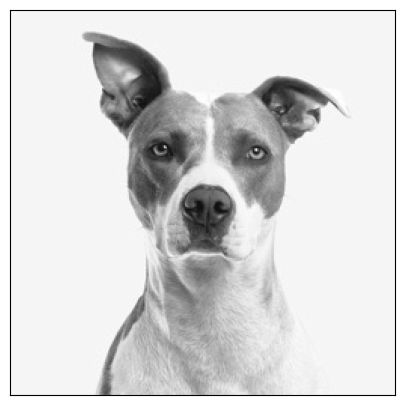

In [7]:
image1 = cv.cvtColor(cv.imread("dog.jpg"), cv.COLOR_BGR2GRAY)[0:512,0:512]; 
image1 = image1/np.max(image1) 
#image2 = cv.cvtColor(cv.imread("image4.jpg"), cv.COLOR_BGR2GRAY)[100-50:612-50,100+450:612+450]; 
#image2 = image2/np.max(image2)
#image3 = cv.cvtColor(cv.imread("image3.jpg"), cv.COLOR_BGR2GRAY)[0+200:1024+200,0+700:1024+700]; 
#image3 = image3/np.max(image3); 
#image3[image3 < 0.02] = 0

N = 512; M=N
N2 = 1024

plot(image1)
#three_across_plots(image1,image2,image3)

### Independent Quantization

Independent quantization follows this equation:

$$ f_q[n,m] = STEP\left\{ \frac{f[n,m] - f_{min}}{f_{max} - f_{min}} - \frac{1}{2} \right\}$$

In all three of my images, $f_{max}$ is 1 and $f_{max}$ is 0. Therefore this equation reduces to: 

$$ f_q[n,m] = STEP\left\{ f[n,m] - \frac{1}{2} \right\}$$

In [8]:
image1_quantized = threshold(np.copy(image1),0.5)
#image2_quantized = threshold(np.copy(image2),0.5)
#image3_quantized = threshold(np.copy(image3),0.5)

#### Error
And therefore the error is,

$$ \epsilon[n,m] = f_q[n,m] - f[n,m] $$

In [9]:
e1 = image1_quantized - image1; #e2 = image2_quantized - image2; #e3 = image3_quantized - image3
e1_sum = np.sum(e1); # e2_sum = np.sum(e2); e3_sum = np.sum(e3)

As noted in the instructions, this error can be deceptful. A better method to estimate error is the RMSE:

#### Root-mean-squared Error (RMSE)

RMSE is calculated using the formula:

$$ \sqrt{\frac{1}{N\cdot M} \sum_{1}^{N}\sum_{1}^{M} \left( \epsilon [n,m]\right)^2 }$$

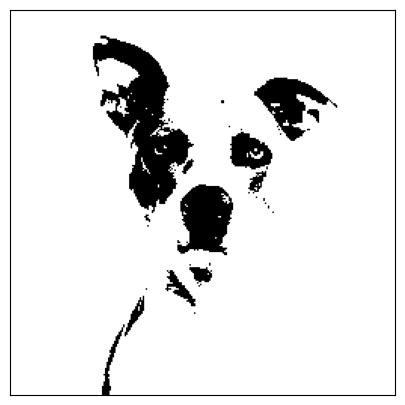

In [10]:
RMSE1 = (np.sum(e1**2)/N/M)**0.5; #RMSE2 = (np.sum(e2**2)/N/M)**0.5; RMSE3 = (np.sum(e3**2)/N/M)**0.5
#three_across_plots(image1_quantized,image2_quantized,image3_quantized,
                  # "RMSE = "+str(round(RMSE1,3)),
                  # "RMSE = "+str(round(RMSE2,3)),
                  # "RMSE = "+str(round(RMSE3,3)))
plot(image1_quantized)

### Error-Diffused (ED) Quantization

In [13]:
def error_diffused_quantizer(image):
    
    N = image.shape[0]
    M = image.shape[1]
    image_edq = np.zeros((N,M))
    
    for i in range(0,N):
        
        for j in range(0,M):
            
            if i==0:
                error_up = 0
            else:
                error_up = image[i-1,j] - image_edq[i-1,j]
            if  i==0 or j==0:
                error_up_left = 0
            else:
                error_up_left = image[i-1,j-1] - image_edq[i-1,j-1]
            if i==0 or j==M-1:
                error_up_right = 0
            else:
                error_up_right = image[i-1,j+1] - image_edq[i-1,j+1]
            if j==0:
                error_left = 0
            else:
                error_left = image[i,j-1] - image_edq[i,j-1]
        
            error = 7/16*error_left + 5/16*error_up + 3/16*error_up_right + 1/16*error_up_left
            
            if (image[i,j] + error) < 0.5:
                image_edq[i,j] = 0
            else:
                image_edq[i,j] = 1

    return image_edq

        

### Applying the Error Diffused Quantization

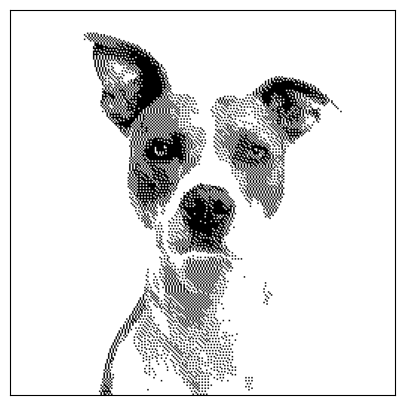

In [32]:
image1_edq = error_diffused_quantizer(image1); RMSE1_edq = (1/N/N*np.sum((image1-image1_edq)**2))**0.5
#image2_edq = error_diffused_quantizer(image2); RMSE2_edq = (1/N/N*np.sum((image2-image2_edq)**2))**0.5
#image3_edq = error_diffused_quantizer(image3); RMSE3_edq = (1/N2/N2*np.sum((image3-image3_edq)**2))**0.5

#three_across_plots(image1,image2,image3,
                   # "Image 1 Original", 
                   # "Image 2 Original",
                   # "Image 3 Original")

#three_across_plots(image1_edq,image2_edq,image3_edq,
                   # "ED Image 1, RMSE = "+str(round(RMSE1_edq,3)),
                   # "ED Image 2, RMSE = "+str(round(RMSE2_edq,3)),
                   # "ED Image 3, RMSE = "+str(round(RMSE3_edq,3)))

#three_across_plots(image1_edq[100:250,350:500],image2_edq[100:250,350:500],image3_edq[350:500,350:500],
                  # "ED Image 1 Magnified",
                  # "ED Image 2 Magnified",
                  # "ED Image 3 Magnified")

plot(image1_edq)

#plot_magnified(image1_edq[100:250,350:500])

Error diffusion seems to do well in representing regions of images with high spatial frequencies. For example, image 3 contains a lot of the high spatial frequencies and those regions of the image look almost identical to the original image. This makes sense as the binary pixels are inherently represent high frequency while they take advantage of the imperfections of the human visual system to simulate low frequencies. 

### Taking the Discrete Fourier Transform of the Images

In [52]:
image1_DFT = abs(DFT_2D(image1))
image1_edq_DFT = abs(DFT_2D(image1_edq)) 

#image2_DFT = abs(DFT_2D(image2))
#image2_edq_DFT = abs(DFT_2D(image2_edq)) 

#image3_DFT = abs(DFT_2D(image3))
#image3_edq_DFT = abs(DFT_2D(image3_edq)) 

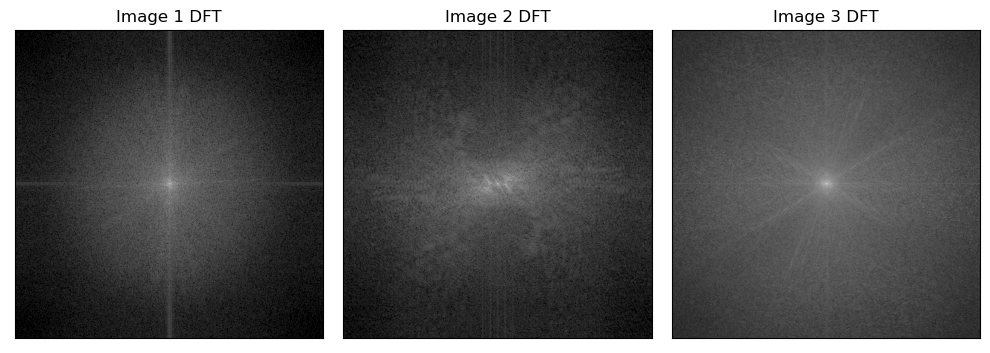

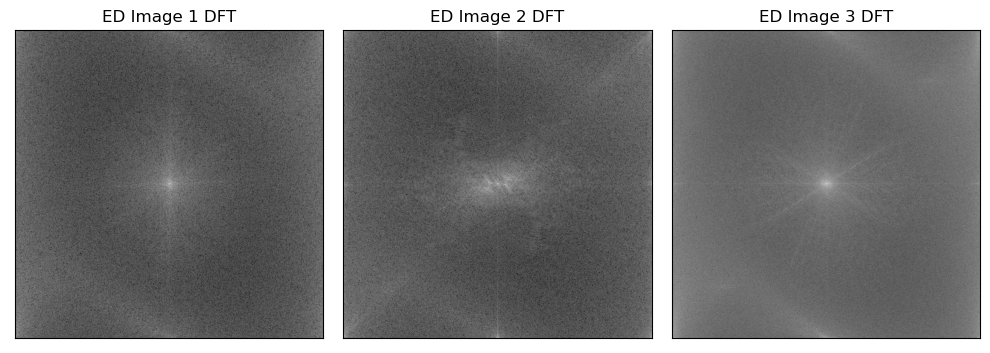

In [53]:
three_across_plots(np.log(image1_DFT),np.log(image2_DFT),np.log(image3_DFT),
                   "Image 1 DFT","Image 2 DFT","Image 3 DFT",
                   vmin=0,vmax=13)
three_across_plots(np.log(image1_edq_DFT),np.log(image2_edq_DFT),np.log(image3_edq_DFT),
                   "ED Image 1 DFT","ED Image 2 DFT","ED Image 3 DFT",
                   vmin=0,vmax=13)

I use a log scale to display the spectra since the variation in the magnitudes are quite high. As expected, high spatial frequency envelope is seen in the binary (error diffused) images. The diagonal lines (located at vertical high frequency values) seem to be an artifact of the error diffusion algorithm. 

### Evaluating the Quantization Errors for Error Diffused Images

In [54]:
error_image1_edq = image1 - image1_edq
#error_image2_edq = image2 - image2_edq
#error_image3_edq = image3 - image3_edq
error_image1_edq_DFT = abs(DFT_2D(error_image1_edq))
#error_image2_edq_DFT = abs(DFT_2D(error_image2_edq))
#error_image3_edq_DFT = abs(DFT_2D(error_image3_edq))

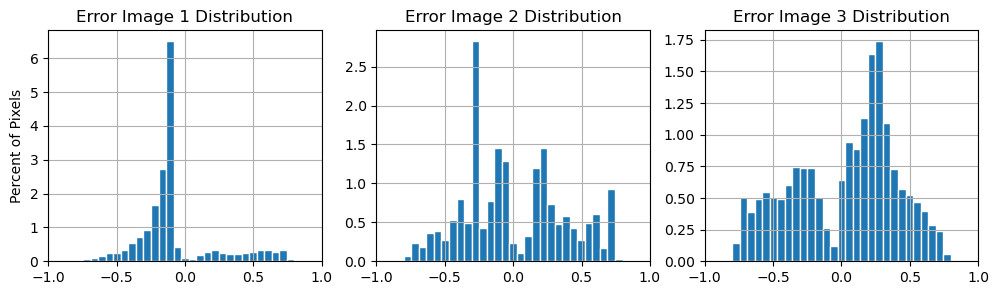

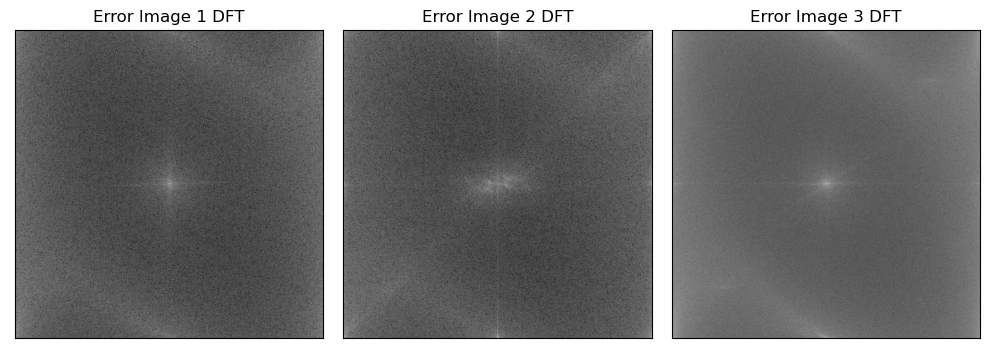

In [55]:
plt.figure(figsize = (12,3))
plt.subplot(1,3,1)
p, bins, patches = plt.hist(error_image1_edq.ravel(),np.linspace(-0.8,0.8,30),density=True,edgecolor="white")
plt.title("Error Image 1 Distribution");plt.grid();plt.xticks(np.linspace(-1,1,5))
plt.ylabel("Percent of Pixels")
plt.subplot(1,3,2)
p, bins, patches = plt.hist(error_image2_edq.ravel(),np.linspace(-0.8,0.8,30),density=True,edgecolor="white")
plt.title("Error Image 2 Distribution");plt.grid();plt.xticks(np.linspace(-1,1,5))
plt.subplot(1,3,3)
p, bins, patches = plt.hist(error_image3_edq.ravel(),np.linspace(-0.8,0.8,30),density=True,edgecolor="white")
plt.title("Error Image 3 Distribution");plt.grid();plt.xticks(np.linspace(-1,1,5))
plt.show()
three_across_plots(np.log(error_image1_edq_DFT),np.log(error_image2_edq_DFT),np.log(error_image3_edq_DFT),
                   "Error Image 1 DFT","Error Image 2 DFT","Error Image 3 DFT",
                   vmin = 0,vmax = 13)

It looks like there is a combination of pink and blue noise. I see two diagonal lines at the top and bottom of all three spectra which seems to be an artifact of my error diffusion algorithm.

### Halftone Dithering

In [18]:
def dither(image):
    n = image.shape[0]
    k = n/512
    x = np.linspace(-n/2,n/2-1,n)
    [X,Y] = np.meshgrid(x,x)
    white_noise_spectrum = np.exp(1j*np.random.uniform(-np.pi,np.pi,(n,n)))
    blue_noise_spectrum = (1-np.exp(-(X**2+Y**2)/k/2e4))*np.exp(1j*np.random.uniform(-np.pi,np.pi,(n,n)))
    white_noise = DFT_2D(white_noise_spectrum)
    blue_noise = DFT_2D(blue_noise_spectrum)
    white_noise_real = white_noise.real
    white_noise_real_normalized = white_noise_real/np.max(white_noise_real)
    blue_noise_real = blue_noise.real
    blue_noise_real_normalized = blue_noise_real/np.max(blue_noise_real)
    image_dithered_blue = threshold(blue_noise_real_normalized + image,1)
    image_dithered_white = threshold(white_noise_real_normalized + image,1)
    return image_dithered_blue, image_dithered_white, blue_noise_spectrum, white_noise_spectrum

image1_dithered_blue, image1_dithered_white, blue_noise_spectrum, white_noise_spectrum = dither(image1)
#image2_dithered_blue, image2_dithered_white, blue_noise_spectrum, white_noise_spectrum = dither(image2)
#image3_dithered_blue, image3_dithered_white, blue_noise_spectrum, white_noise_spectrum= dither(image3)

NameError: name 'image2' is not defined

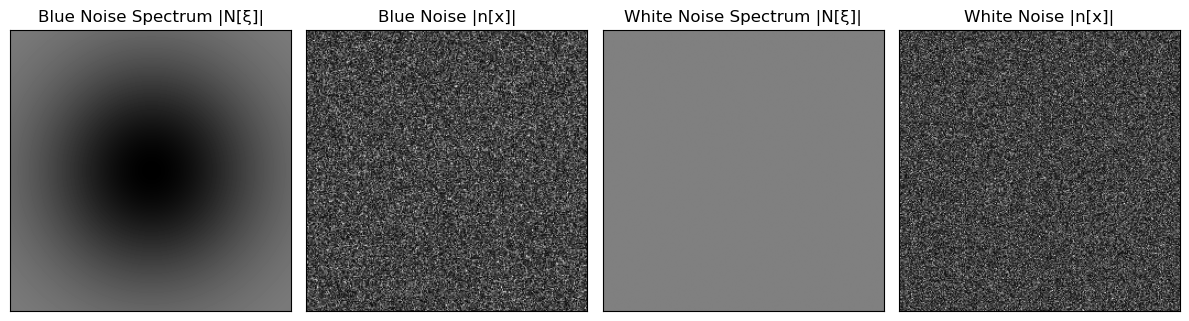

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(1,4,1)
imsow(abs(blue_noise_spectrum),minv=0,maxv=2)
plt.title("Blue Noise Spectrum |N[ξ]|")
plt.subplot(1,4,2)
imsow((abs(DFT_2D(blue_noise_spectrum)))/np.max(abs(DFT_2D(blue_noise_spectrum))))
plt.title("Blue Noise |n[x]|")
plt.subplot(1,4,3)
imsow(((abs((white_noise_spectrum)))),minv=0,maxv=2)
plt.title("White Noise Spectrum |N[ξ]|")
plt.subplot(1,4,4)
imsow((abs(DFT_2D(white_noise_spectrum)))/np.max(abs(DFT_2D(white_noise_spectrum))))
plt.title("White Noise |n[x]|")
plt.tight_layout()
plt.show()

#### Blue-Noise Dithering

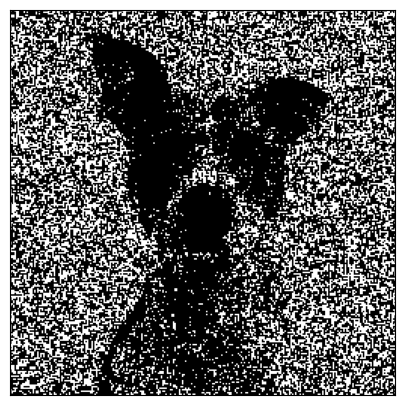

In [33]:
# three_across_plots(image1,
                   # image2,
                   # image3,
                   # "Image 1 Original","Image 2 Original","Image 3 Original")

# three_across_plots(image1_dithered_blue,
                   # image2_dithered_blue,
                   # image3_dithered_blue,
                   # "Image 1 Dithered","Image 2 Dithered","Image 3 Dithered")
# three_across_plots(image1_dithered_blue[100:250,350:500],
                   # image2_dithered_blue[100:250,350:500],
                   # image3_dithered_blue[350:500,350:500]
                   # ,"Image 1 Dithered Magnified","Image 2 Dithered Magnified","Image 3 Dithered Magnified")

plot(image1_dithered_blue)


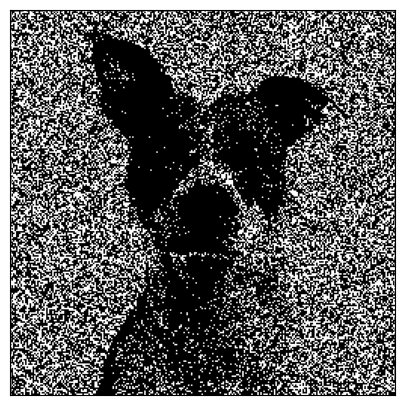

In [34]:
# three_across_plots(image1,
                    # image2,
                    # image3,
                    # "Image 1 Original","Image 2 Original","Image 3 Original")

# three_across_plots(image1_dithered_white,
                   # image2_dithered_white,
                   # image3_dithered_white,
                   # "Image 1 Dithered","Image 2 Dithered","Image 3 Dithered")
# three_across_plots(image1_dithered_white[100:250,350:500],
                   # image2_dithered_white[100:250,350:500],
                   # image3_dithered_white[350:500,350:500]
                  # ,"Image 1 Dithered Magnified","Image 2 Dithered Magnified","Image 3 Dithered Magnified")

plot(image1_dithered_white)

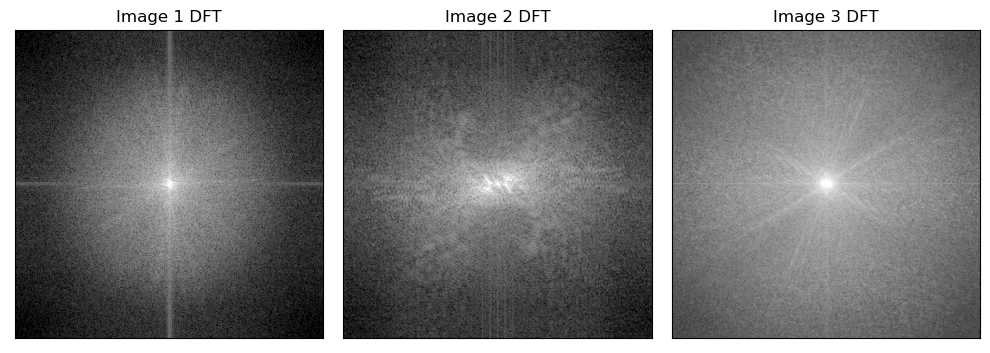

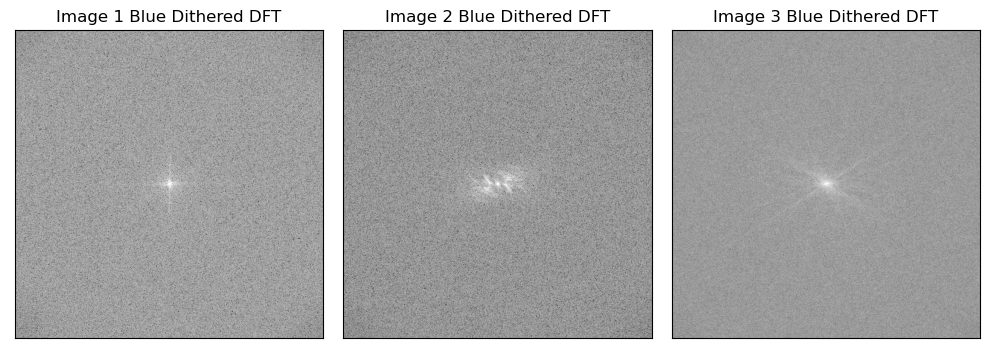

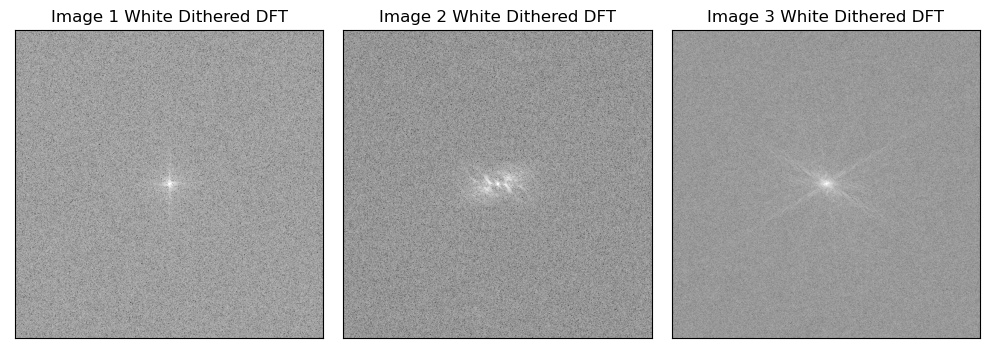

In [70]:
image1_dithered_blue_DFT = abs(DFT_2D(image1_dithered_blue))
image2_dithered_blue_DFT = abs(DFT_2D(image2_dithered_blue))
image3_dithered_blue_DFT = abs(DFT_2D(image3_dithered_blue))
image1_dithered_white_DFT = abs(DFT_2D(image1_dithered_white))
image2_dithered_white_DFT = abs(DFT_2D(image2_dithered_white))
image3_dithered_white_DFT = abs(DFT_2D(image3_dithered_white))

three_across_plots(np.log(image1_DFT),np.log(image2_DFT),np.log(image3_DFT)
                  ,"Image 1 DFT","Image 2 DFT","Image 3 DFT"
                  ,vmin = 0, vmax = 8)

three_across_plots(np.log(image1_dithered_blue_DFT),np.log(image2_dithered_blue_DFT),np.log(image3_dithered_blue_DFT)
                  ,"Image 1 Blue Dithered DFT","Image 2 Blue Dithered DFT","Image 3 Blue Dithered DFT"
                  ,vmin = 0, vmax = 8)
three_across_plots(np.log(image1_dithered_white_DFT),np.log(image2_dithered_white_DFT),np.log(image3_dithered_white_DFT)
                  ,"Image 1 White Dithered DFT","Image 2 White Dithered DFT","Image 3 White Dithered DFT"
                  ,vmin = 0, vmax = 8)

In both the white and blue noise dithered spectra there is a larger magnitude of higher frequencies. That makes sense since both noise spectra contained high frequencies. The central features in the blue-noise spectra are smaller than in the white noise spectra, which makes sense since blue noise disproportionally adds higher frequencies as compared to low frequencies. 

## Halftone Removal

### Loading Image

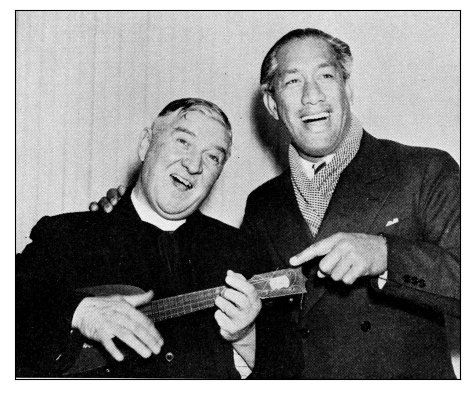

In [18]:
image_ht = cv.cvtColor(cv.imread("Kahanamoku_Jan-37_cropped_bitmap.tif"), cv.COLOR_BGR2GRAY)
image_ht = image_ht/np.max(image_ht)
imsow(image_ht)

#### Taking the DFT

In [19]:
image_ht_DFT = DFT_2D(image_ht)

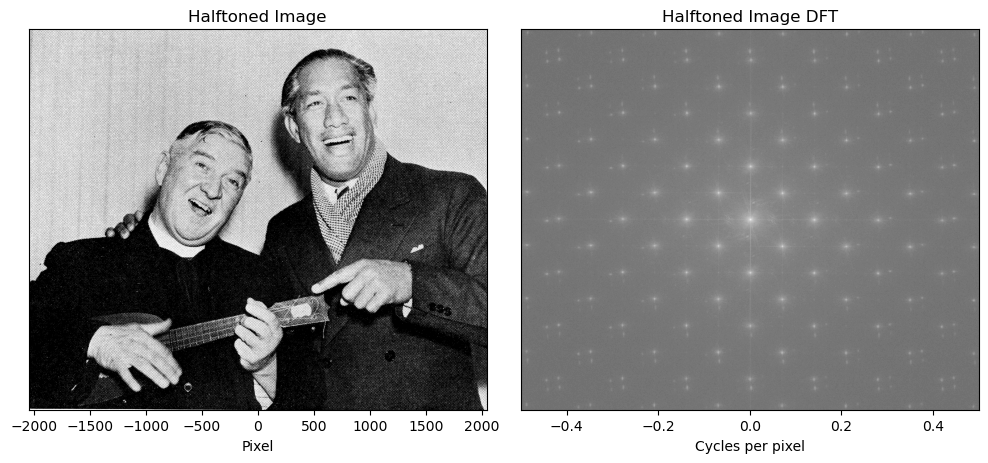

In [20]:
o = 3394/4088
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title("Halftoned Image")
plt.imshow(image_ht,cmap="gray",extent=[-4088/2,4088/2-1,-3394/2,3394/2-1])
plt.yticks([]);
plt.xlabel("Pixel")
plt.subplot(1,2,2)
plt.imshow(np.log(abs(image_ht_DFT)),extent=[-1/2,1/2-1/4088,-o/2,o/2-o/4088],
           vmin = 0, vmax = 13,cmap="gray");plt.yticks([])
plt.title("Halftoned Image DFT")
plt.xlabel("Cycles per pixel")
plt.tight_layout()

Note that again, a log scale is used for displaying the spectrum.

A periodic pattern is seen in the spectrum. A periodic spectrum is a result of a sampled function. Here the largest frequency presented is not the largest frequency possible digitally (i.e: the pixel size is smaller than the halftone dot size). Therefore, a repeated pattern of the same dot is seen in the spectrum. 

Let's examine how the halftone dot size compares to the pixel size in the image:

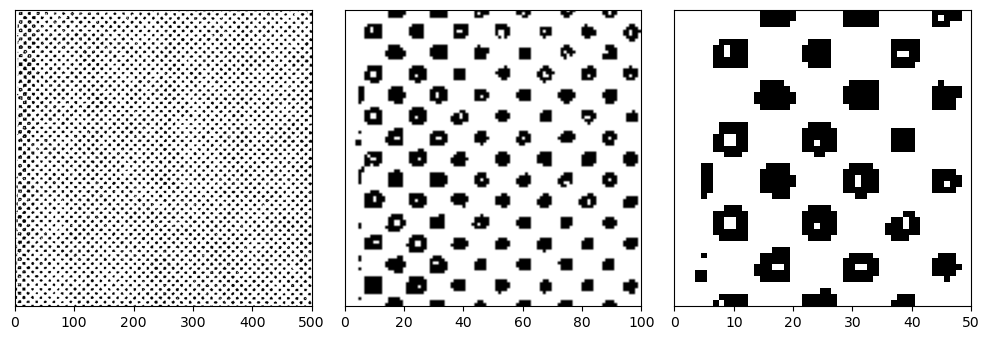

In [21]:
plt.figure(figsize = (10,5))
plt.subplot(1,3,1)
plt.imshow(image_ht[0:500,0:500],cmap="gray");plt.yticks([]);plt.xlim(0,500)
plt.subplot(1,3,2)
plt.imshow(image_ht[0:100,0:100],cmap="gray");plt.yticks([]);plt.xlim(0,100)
plt.subplot(1,3,3)
plt.imshow(image_ht[0:50,0:50],cmap="gray");plt.yticks([]);plt.xlim(0,50)
plt.tight_layout()
plt.show()

As seen, there are about 7 dots in 50 pixels. Maximum represented frequency in the image can therefore be: 

$$ \frac{1}{2} \frac{cycles}{dot} \times \frac{7}{50} \frac{dot}{pixels} = \frac{7}{100}\frac{cycles}{pixels} = 0.07 \frac{cycles}{pixels} $$. 

Which means that any information represented in the spectrum above beyond $0.07$ cycles per pixel is only used to construct the discontinuity created by the samples. All the information above that frequency is unavailable. Theoretically, to remove the halftone pattern we just need to attenuate the spectrum above this frequency. Below I create some variations of low pass masks to attenuate high frequencies.

In [22]:
k = np.linspace(-4088/2,4088/2-1,4088)
l = np.linspace(-3394/2,3394/2-1,3394)
[K,L] = np.meshgrid(k/4088,l/4088/o)

mask_ideal = (K<0.07) * (K>-0.07) * (L<0.07) * (L>-0.07)
mask_big = (K<0.4) * (K>-0.4) * (L<0.4) * (L>-0.4)
mask_small = (K<0.025) * (K>-0.025) * (L<0.025) * (L>-0.025)

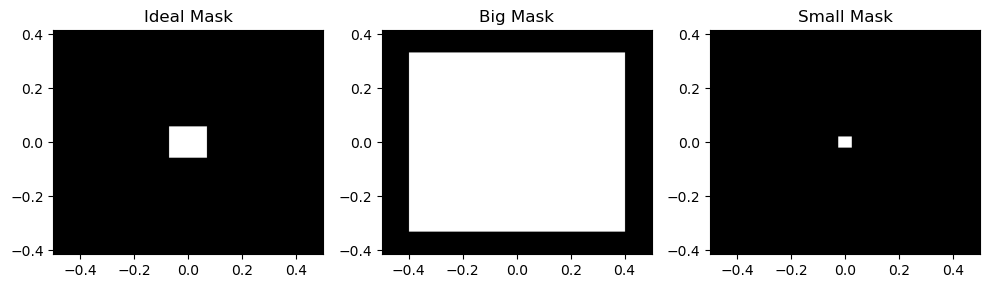

In [23]:
plt.figure(figsize = (10,5))
plt.subplot(1,3,1)
plt.imshow(mask_ideal,cmap="gray",extent=[-1/2,1/2-1/4088,-o/2,o/2-o/4088]);plt.xlim(-0.5,0.5)
plt.title("Ideal Mask")
plt.subplot(1,3,2)
plt.imshow(mask_big,cmap="gray",extent=[-1/2,1/2-1/4088,-o/2,o/2-o/4088]);plt.xlim(-0.5,0.5)
plt.title("Big Mask")
plt.subplot(1,3,3)
plt.imshow(mask_small,cmap="gray",extent=[-1/2,1/2-1/4088,-o/2,o/2-o/4088]);plt.xlim(-0.5,0.5)
plt.title("Small Mask")
plt.tight_layout()
plt.show()

We can apply these masks to the spectrum:

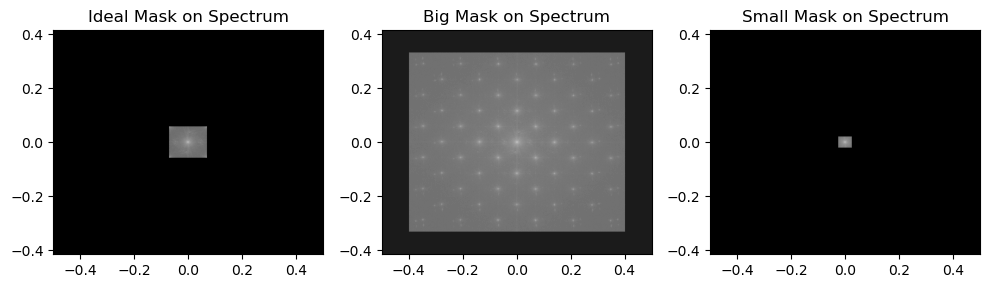

In [24]:
plt.figure(figsize = (10,5))
plt.subplot(1,3,1)
plt.imshow(mask_ideal*np.log(abs(image_ht_DFT)),cmap="gray",extent=[-1/2,1/2-1/4088,-o/2,o/2-o/4088]);plt.xlim(-0.5,0.5)
plt.title("Ideal Mask on Spectrum")
plt.subplot(1,3,2)
plt.imshow(mask_big*np.log(abs(image_ht_DFT)),cmap="gray",extent=[-1/2,1/2-1/4088,-o/2,o/2-o/4088]);plt.xlim(-0.5,0.5)
plt.title("Big Mask on Spectrum")
plt.subplot(1,3,3)
plt.imshow(mask_small*np.log(abs(image_ht_DFT)),cmap="gray",extent=[-1/2,1/2-1/4088,-o/2,o/2-o/4088]);plt.xlim(-0.5,0.5)
plt.title("Small Mask on Spectrum")
plt.tight_layout()
plt.show()

And now taking the inverse transform..

In [25]:
image_ht_DFT_ideal_mask = mask_ideal * image_ht_DFT
image_ht_DFT_small_mask = mask_small * image_ht_DFT
image_ht_DFT_big_mask = mask_big * image_ht_DFT
image_ht_ideal_mask = np.fft.fftshift(np.flipud(np.fliplr(DFT_2D(image_ht_DFT_ideal_mask))))
image_ht_small_mask = np.fft.fftshift(np.flipud(np.fliplr(DFT_2D(image_ht_DFT_small_mask))))
image_ht_big_mask = np.fft.fftshift(np.flipud(np.fliplr(DFT_2D(image_ht_DFT_big_mask))))

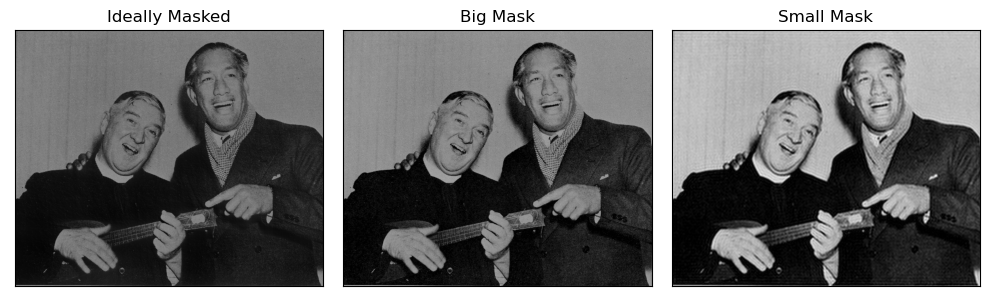

In [26]:
three_across_plots(abs(image_ht_ideal_mask)/np.max(abs(image_ht_ideal_mask)),
                   abs(image_ht_big_mask)/np.max(abs(image_ht_big_mask)),
                   abs(image_ht_small_mask)/np.max(abs(image_ht_small_mask)),
                  "Ideally Masked","Big Mask","Small Mask")

Zooming in...

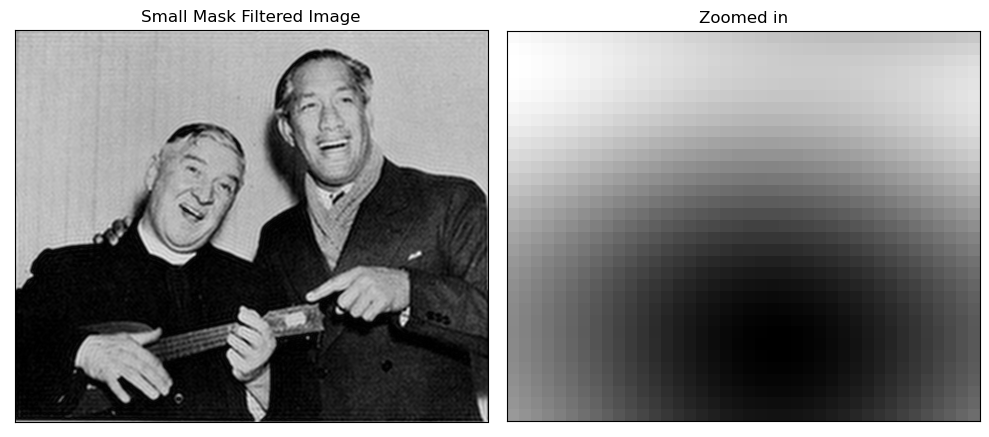

In [27]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(abs(image_ht_small_mask)/np.max(abs(image_ht_small_mask)),cmap="gray");plt.xticks([]);plt.yticks([])
plt.title("Small Mask Filtered Image")
plt.subplot(1,2,2)
plt.imshow((abs(image_ht_small_mask)/np.max(abs(image_ht_small_mask)))[0:33,0:40],
           cmap="gray");plt.xticks([]);plt.yticks([])
plt.title("Zoomed in")
plt.tight_layout()
plt.show()

Halftone dots are completely removed here, but the image is blurred. 

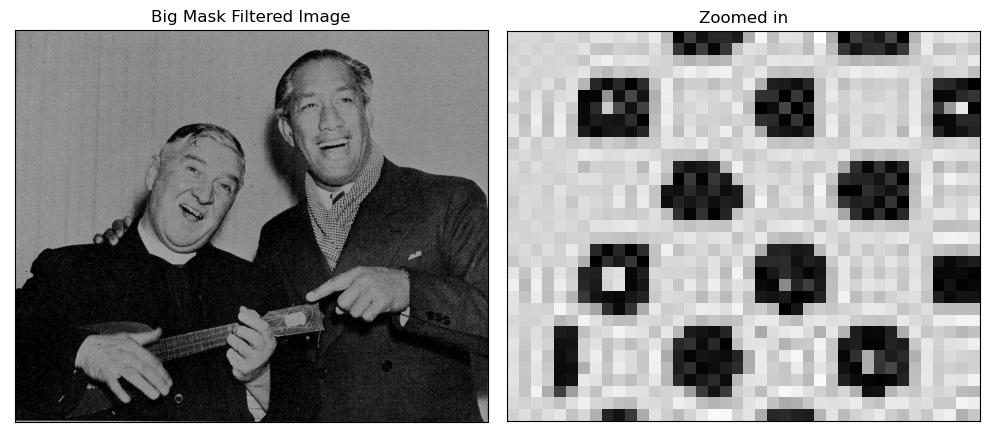

In [28]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(abs(image_ht_big_mask)/np.max(abs(image_ht_big_mask)),cmap="gray");plt.xticks([]);plt.yticks([])
plt.title("Big Mask Filtered Image")
plt.subplot(1,2,2)
plt.imshow((abs(image_ht_big_mask)/np.max(abs(image_ht_big_mask)))[0:33,0:40],
           cmap="gray");plt.xticks([]);plt.yticks([])
plt.title("Zoomed in")
plt.tight_layout()
plt.show()

Halftone dots are completely visible here.

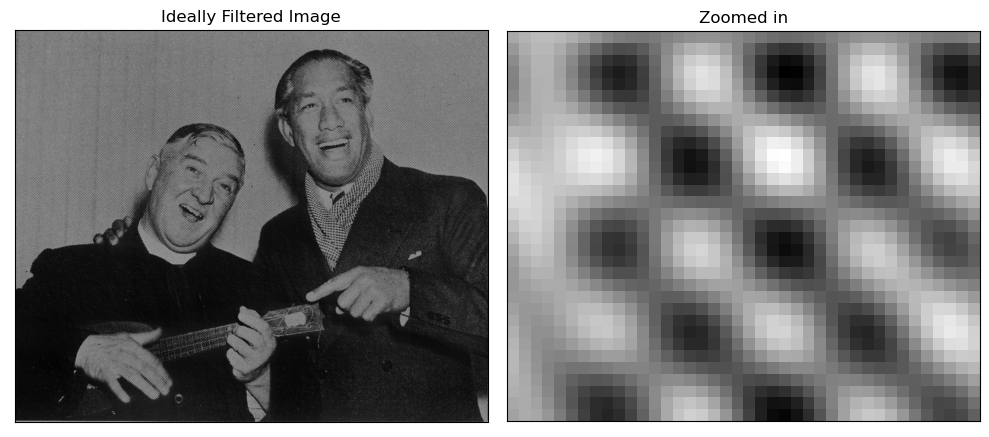

In [29]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(abs(image_ht_ideal_mask)/np.max(abs(image_ht_ideal_mask)),cmap="gray");plt.xticks([]);plt.yticks([])
plt.title("Ideally Filtered Image")
plt.subplot(1,2,2)
plt.imshow((abs(image_ht_ideal_mask)/np.max(abs(image_ht_ideal_mask)))[0:33,0:40],
           cmap="gray");plt.xticks([]);plt.yticks([])
plt.title("Zoomed in")
plt.tight_layout()
plt.show()

The halftone dots are just started to be blurred out. Slightly adjusting the mask below:

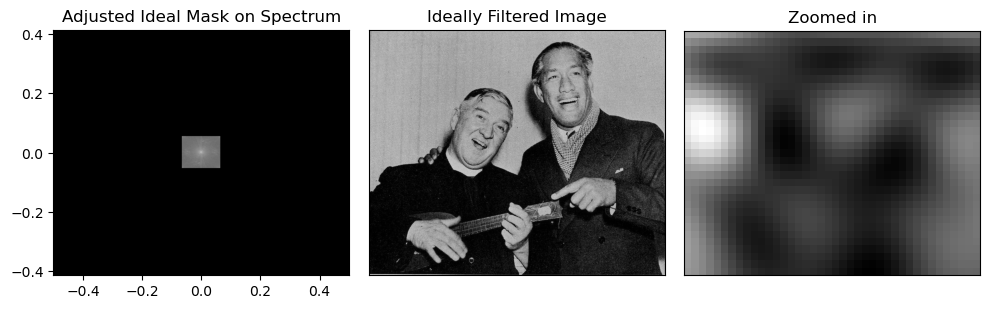

In [30]:
mask_ideal2 = (K<0.065) * (K>-0.065) * (L<0.065) * (L>-0.065)
image_ht_DFT_ideal2_mask = mask_ideal2 * image_ht_DFT
image_ht_ideal2_mask = np.fft.fftshift(np.flipud(np.fliplr(DFT_2D(image_ht_DFT_ideal2_mask))))
plt.figure(figsize = (10,5))
plt.subplot(1,3,1)
plt.imshow(mask_ideal2*np.log(abs(image_ht_DFT)),cmap="gray",extent=[-1/2,1/2-1/4088,-o/2,o/2-o/4088]);plt.xlim(-0.5,0.5)
plt.title("Adjusted Ideal Mask on Spectrum")
plt.subplot(1,3,2)
plt.imshow(abs(image_ht_ideal2_mask)/np.max(abs(image_ht_ideal2_mask)),cmap="gray");plt.xticks([]);plt.yticks([])
plt.title("Ideally Filtered Image")
plt.subplot(1,3,3)
plt.imshow((abs(image_ht_ideal2_mask)/np.max(abs(image_ht_ideal2_mask)))[0:33,0:40],
           cmap="gray");plt.xticks([]);plt.yticks([])
plt.title("Zoomed in")
plt.tight_layout()
plt.show()

The halftone dots are completely removed. 

Comparing with the original image:

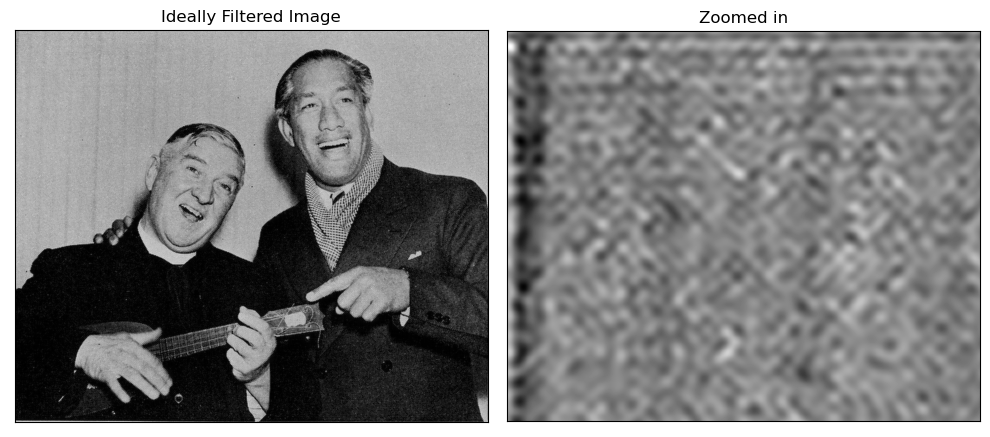

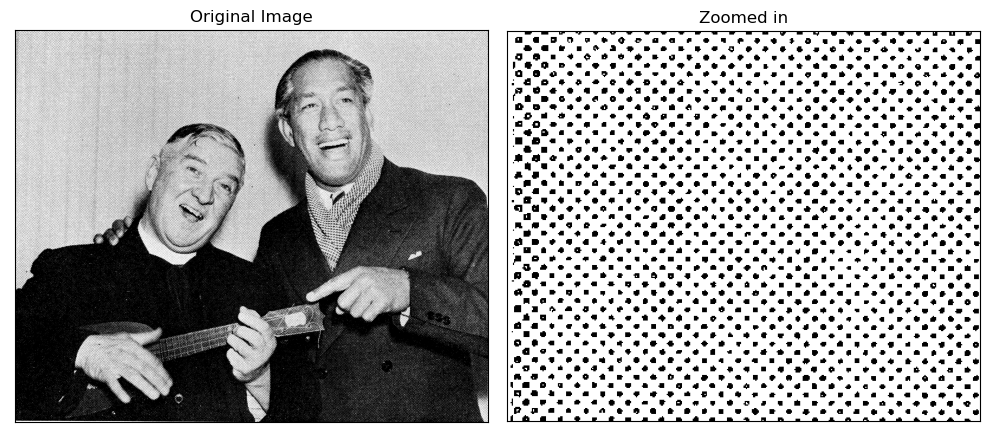

In [31]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(abs(image_ht_ideal2_mask)/np.max(abs(image_ht_ideal2_mask)),cmap="gray");plt.xticks([]);plt.yticks([])
plt.title("Ideally Filtered Image")
plt.subplot(1,2,2)
plt.imshow((abs(image_ht_ideal2_mask)/np.max(abs(image_ht_ideal2_mask)))[0:330,0:400],
           cmap="gray");plt.xticks([]);plt.yticks([])
plt.title("Zoomed in")
plt.tight_layout()
plt.show()
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(abs(image_ht)/np.max(abs(image_ht)),cmap="gray");plt.xticks([]);plt.yticks([])
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow((abs(image_ht)/np.max(abs(image_ht)))[0:330,0:400],
           cmap="gray");plt.xticks([]);plt.yticks([])
plt.title("Zoomed in")
plt.tight_layout()
plt.show()

As we can see the halftone dots are quite convincingly removed here. It does seem as if what has replaced it is just random noise. That would make sense as the information filling the gaps is not available to us so we cannot accurately predict it. 